In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io
import numpy as np
import glob

from vae import VariationalAutoencoder

In [2]:
files = (glob.glob('Coll*/data/*/*/*/Pr*ta/*rec.tif'))

In [3]:
Xs = []
for file in files:
    im = io.imread(file)
    Xs.append(im)

In [4]:
Xs[0].shape

(461, 497, 461)

In [5]:
X = []
y = []
for x in Xs:
    im = x[:,::8,::7]
    _,xx,yy = im.shape
    fix_x = xx-60
    fix_y = yy-60
    if (fix_x%2==1):
        im = im[:,fix_x//2:-(fix_x//2+1)]
    elif (fix_x>0):
        im = im[:,fix_x//2:-(fix_x//2)]
    if (fix_y%2==1):
        im = im[:,:,fix_y//2:-(fix_y//2+1)]
    elif (fix_y>0):
        im = im[:,:,fix_y//2:-(fix_y//2)]
    X.append(im)
    y.append(np.arange(60,400))

In [6]:
X = np.concatenate((X))
y = np.concatenate((y))

280.71393
0.075704224 0.26775357


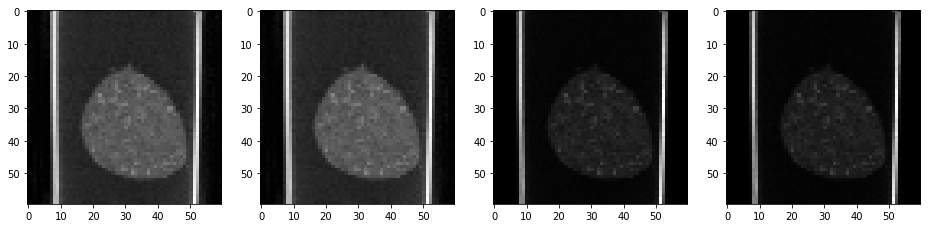

In [7]:
fig,ax = plt.subplots(ncols=4,figsize=(16,6))

idx = np.random.randint(len(X))

ax[0].imshow(X[idx],cmap='gray')

x = X[idx]
proc = (x-x.min())/(x.max()-x.min())
ax[1].imshow(proc,cmap='gray')

proc = proc**2
ax[2].imshow(proc,cmap='gray')

x = X[idx]**2
proc = (x-x.min())/(x.max()-x.min())
print(proc.sum())
print(X[idx].sum(axis=1).std(),X[idx].sum(axis=0).std())
ax[3].imshow(proc,cmap='gray')

plt.show()

In [8]:
# clean all the white vertical lines
# these lines are just artifacts from the imaging process
for idx in range(len(X)):
    cols = X[idx].sum(axis=0)
    for i in range(len(cols)):
        if cols[i]>0.7:
            X[idx,:,i] = 0

In [9]:
# remove images that are mostly blank (after removing the vertical lines)
keep = []
for i in range(len(X)):
    if X[i].sum()>5:
        keep.append(i)

In [10]:
# prune data
X = X[keep]

In [11]:
# normalize data
X = X-X.min()
X = X/X.max()
X = X**2

In [12]:
# flatten data
X_train = np.zeros((len(X),3600))

for i in range(len(X)):
    X_train[i] = X[i].flatten()

In [17]:
# add all mirror images
X_flip=X_train.copy()
for i in range(len(X_flip)):
    x = X_flip[i].reshape(60,60)
    x = np.flip(x,axis=1).flatten()
    X_flip[i] = x
    
X_double = np.concatenate([X_train,X_flip])
np.random.shuffle(X_double)

In [21]:
X_double.shape

(10200, 3600)

In [41]:
va = VariationalAutoencoder(3600,[1024,64],ent_weight=4)

In [42]:
# several iterations of training
va.fit(X_double,batch=10,epochs=10)

Epoch: 1
Cost: -18842128.325195312
Epoch: 2
Cost: -18010365.360351562
Epoch: 3
Cost: -17840676.821289062
Epoch: 4
Cost: -17735291.53515625
Epoch: 5
Cost: -17656115.802734375
Epoch: 6
Cost: -17601839.640625
Epoch: 7
Cost: -17558246.137695312
Epoch: 8
Cost: -17526302.3125
Epoch: 9
Cost: -17500397.143554688
Epoch: 10
Cost: -17477385.614257812


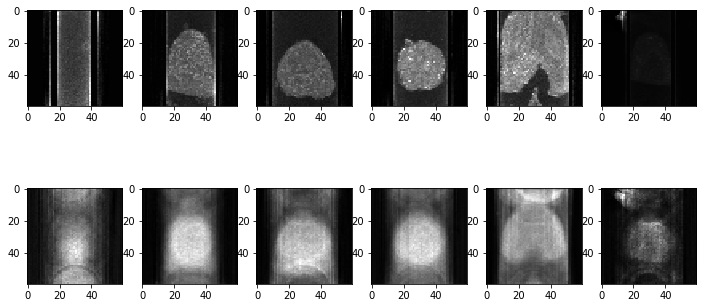

In [43]:
# reconstruct images
fig,ax = plt.subplots(ncols=6,nrows=2,figsize=(12,6))

for i in range(6):
    idx = np.random.randint(len(X_train))
    ax[0,i].imshow(X_train[idx].reshape(60,60),cmap='gray')
    ae = va.predict(X_train[idx:idx+1])
    ax[1,i].imshow(ae.reshape(60,60),cmap='gray')
plt.show()

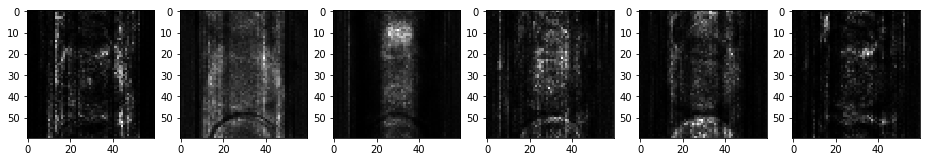

In [44]:
# generate novel images
n = 6
genN = va.generate(n)

fig,ax = plt.subplots(ncols=n,figsize=(16,6))

for i in range(n):
    ax[i].imshow((genN[i].reshape(60,60)),cmap='gray')
plt.show()